In [22]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
import sys
from matplotlib import pyplot
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [3]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

170498071/170498071 [==============================] - 13s 0us/step


In [5]:
X_train.shape

(50000, 32, 32, 3)

In [6]:
X_test.shape

(10000, 32, 32, 3)

In [7]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])

        temp = concat

    return temp

## transition Block
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [8]:
num_filter = 12
dropout_rate = 0.2
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

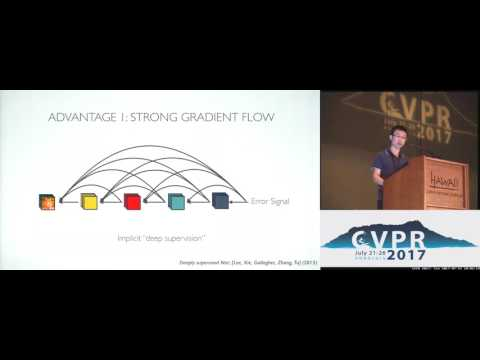

In [9]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [10]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 12)           324       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 12)           48        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 12)           0         ['batch_normalization[0][0

In [11]:
print(len(model.layers))

262


In [12]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [15]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/10
313/313 [==============================] - 50s 159ms/step - loss: 1.6827 - accuracy: 0.3638 - val_loss: 2.2840 - val_accuracy: 0.3004
Epoch 2/10
313/313 [==============================] - 43s 137ms/step - loss: 1.3966 - accuracy: 0.4823 - val_loss: 1.4090 - val_accuracy: 0.5025
Epoch 3/10
313/313 [==============================] - 43s 139ms/step - loss: 1.2556 - accuracy: 0.5441 - val_loss: 2.2005 - val_accuracy: 0.4331
Epoch 4/10
313/313 [==============================] - 43s 136ms/step - loss: 1.1612 - accuracy: 0.5789 - val_loss: 1.3313 - val_accuracy: 0.5606
Epoch 5/10
313/313 [==============================] - 43s 138ms/step - loss: 1.0832 - accuracy: 0.6066 - val_loss: 1.1675 - val_accuracy: 0.5999
Epoch 6/10
313/313 [==============================] - 42s 136ms/step - loss: 1.0300 - accuracy: 0.6291 - val_loss: 1.2737 - val_accuracy: 0.6007
Epoch 7/10
313/313 [==============================] - 42s 136ms/step - loss: 0.9906 - accuracy: 0.6438 - val_loss: 1.2425 - val_ac

In [16]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 4s 9ms/step - loss: 1.1934 - accuracy: 0.6279
Test loss: 1.1934465169906616
Test accuracy: 0.6279000043869019


In [17]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


In [28]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
 # plot loss
 pyplot.subplot(211)
 pyplot.title('Cross Entropy Loss')
 pyplot.plot(history.history['loss'], color='blue', label='train')
 pyplot.plot(history.history['val_loss'], color='orange', label='test')
 # plot accuracy
 pyplot.subplot(212)
 pyplot.title('Classification Accuracy')
 pyplot.plot(history.history['accuracy'], color='blue', label='train')
 pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
 # save plot to file
 #filename = sys.argv[0].split('/')[-1]
 #pyplot.savefig(filename + '_plot.png')
 #pyplot.close()


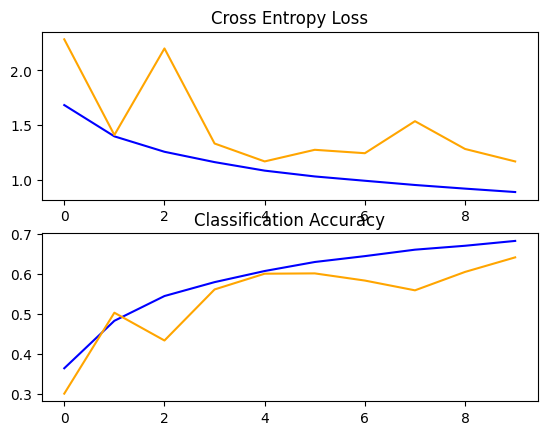

In [29]:
summarize_diagnostics(history)